# Transient dynamics 

In [49]:
include("../age_structure/age_structure_model.jl")
include("../age_structure/fecundity_at_age.jl")
include("i_state_dsn_pedigree_triat.jl")
using LinearAlgebra
using Plots
using Roots
using Distributions

In [50]:
# single paramters 
A_max = 100 # max age
A_mature = 0 # age at maturity 
f_infty = 10.0^6 # maximum fecundity 
k = 0.1 # growth rate 
a0 = 10.0 # growth paramter
s = 0.95 # survival rate


# vectorized paramters
fecundity = broadcast(x -> fecundity_at_age.isometric_LVB(x,f_infty,k,a0), 1:A_max)
survival = repeat([s],A_max)

A = age_structure_model.build_age_matrix(A_max,fecundity,survival)
print(" ")

# Influence function

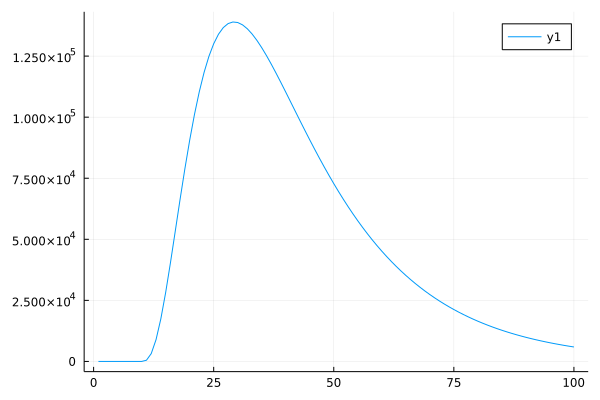

In [51]:
survived = zeros(length(survival))

for i in 1:length(survival)
    survived[i] = prod(survival[1:i])
end
T_ = sum(fecundity.*survived .* collect(1:A_max) ./ sum(fecundity.*survived))
Plots.plot(fecundity.*survived .* collect(1:A_max .> A_mature))



## Expected life time egg production 

In [52]:
LEP = age_structure_model.LEP(1.0, survival, fecundity, A_max )

5.401527237144553e6

## Density dependent survival 

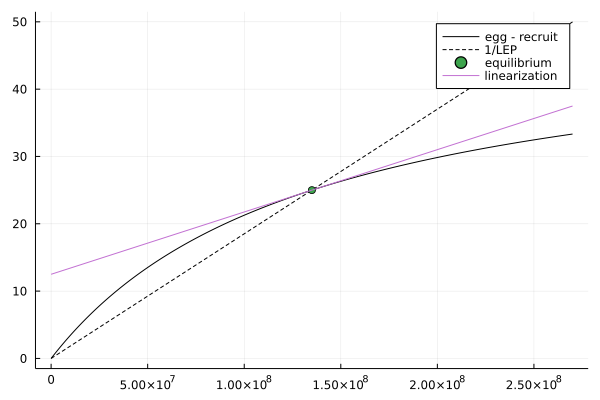

In [53]:
r = 2.0
K = 50
e_max = K*LEP
a = r/LEP
b = a/K
F(x,a,b) = a*x/(1+b*x)
f = x -> F(x,a,b) 
g = x -> F(x,a,b) - x/LEP
x = 0:10^5:e_max
Plots.plot(x, f.(x), color = "black", label = "egg - recruit")
Plots.plot!(x, x./LEP, color = "black", linestyle = :dash, label = "1/LEP")
x_eq = Roots.find_zero(g, (1, e_max))
y_eq = f(x_eq)
Plots.scatter!([x_eq],[y_eq], label = "equilibrium")
Plots.plot!(x,x./(a*LEP^2) .+(f(x_eq)-x_eq/(a*LEP^2)) , label = "linearization")

# Simulations with genetic effects
## parameters

In [118]:
min = -7.5
max = 15
dx = 0.1
grid = min:dx:max

s = 0.1
theta = 0
theta_1 = 5.0
Vle = 1.0
gradient = exp.(-s/2*(grid .- theta).^2)
d = Distributions.Normal(theta_1,sqrt(Vle))
dsn_im = pdf.(d,grid)
dsn_im = dsn_im ./ sum(dsn_im)
print(" ")

In [119]:
h(x) = 0.5/(1/x+s) + 0.5*Vle - x
Veq = Roots.find_zero(h, (0,2*Vle))
d = Distributions.Normal(theta,sqrt(Veq))
dsn = pdf.(d,grid)
dsn = dsn ./ sum(dsn)
adj = sum(dsn.*gradient)

0.9568548076785355

In [120]:

pop = i_state_dsn_pedigree_trait.init_population(A_max, survival, fecundity, r ,K, theta, s, min, max, dx, 4, Vle)

function update!(pop, R_im, dsn_im)

    # reproduction
    dsn, F = i_state_dsn_pedigree_trait.reproduction(pop)
    

    # seleciton
    dsn, R = i_state_dsn_pedigree_trait.selection(dsn, F, pop)
    R = R/adj
    # immigration
    dsn, R = i_state_dsn_pedigree_trait.immigration(dsn, R, dsn_im, R_im*R,pop)
    # dentisy dependence
    R = i_state_dsn_pedigree_trait.recruitment(R, pop)
    # ageing!
    pop = i_state_dsn_pedigree_trait.ageing!(pop, R, dsn)

    return pop
end

update! (generic function with 1 method)

here

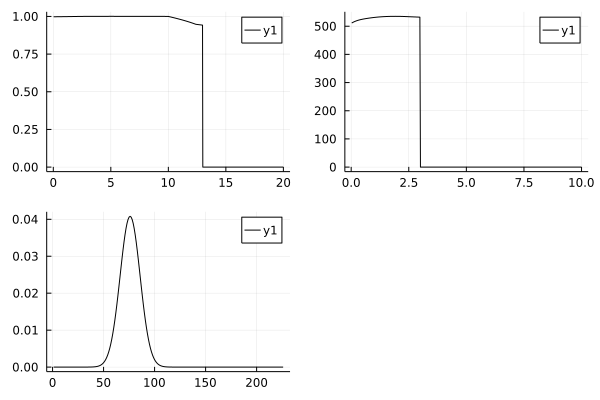

In [121]:
N = floor(Int,10*T_)
R_im = vcat(repeat([0],N), repeat([0.1],floor(Int,3*T_)), repeat([0],N))

n = zeros(2*N)
f = zeros(2*N)
W = zeros(2*N)

#Plots.plot(pop.trait[:,1])
for i in 1:(N+floor(Int,3*T_))
    update!(pop, R_im[i], dsn_im)
    n[i] = sum(pop.abundance)
    W[i] = i_state_dsn_pedigree_trait.fittness(pop)

end 
print("here")
#Plots.plot(n./n[1])
#p1 = Plots.plot((1:N)./T_, W[(N+1):end]./W[N], color = "black")
p1 = Plots.plot((1:2*N)./T_, W./W[N], color = "black")
#Plots.vline!([N./T_], color = "black", linestyle = :dash, legend = false)
p2 = Plots.plot((1:N)./T_, n[(N+1):end], color = "black")
plot(p1,p2,p3)

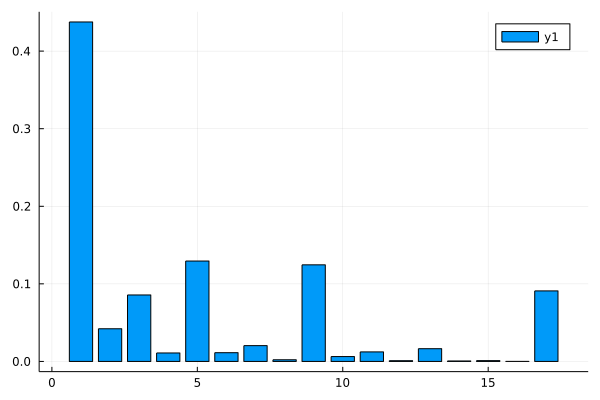

In [117]:
v1 = v1 = 


Plots.bar(mapslices(sum,pop.trait[1],dims = 2))

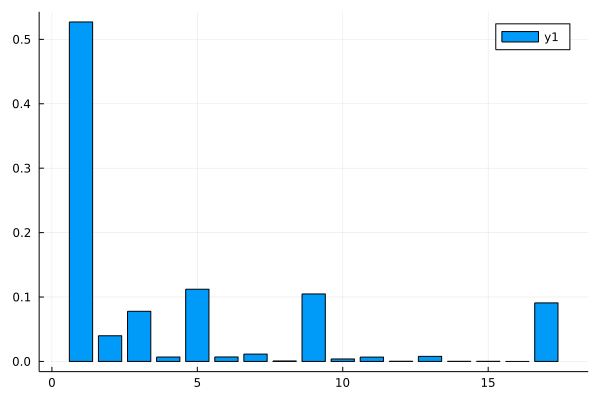

In [122]:
Plots.bar(mapslices(sum,pop.trait[1],dims = 2))